In [86]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import tree
from sklearn.tree import export_graphviz
import mglearn
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Setup

In [87]:
stop_words = set(stopwords.words('english'))

In [88]:
def read_text(file_path):
    with open(file_path) as f:
        contents = f.read()
    raw = contents.split('.')
        
    return raw

In [89]:
def read_text2(file_path):
    with open(file_path) as f:
        contents = f.read()
    raw = contents.split('.')
    
    return raw

In [90]:
def filter_text(raw, lower_range, upper_range):
    filtered_text=[]
    signs = [",", "!", ".", ":", ";", "?", "--", "``", ")", "''", "'", "("]
    names = ["GLOUCESTER", "KENT", "EDMUND", "GONERIL", "CORDELIA", "KING", "LEAR", "ALBANY", "EDGAR", "REGAN", "OSWALD"]

    for item in raw:
        if item:
            item_str=item.replace("\n", " ")            
            word_tokens = word_tokenize(item_str)
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words and w not in signs and w not in names] # this is just for counting
            filtered_sentence_full = [w for w in word_tokens if w not in names]
            if len(filtered_sentence) >=lower_range and len(filtered_sentence) < upper_range:
                sentence = " ".join(filtered_sentence_full)
                filtered_text.append(sentence)
    return filtered_text


raw = read_text('A-Tale-of-Two-Cities.txt')

filtered_text_tales_cities = filter_text(raw, 10, 15)

print("length of tales of two cities:", len(filtered_text_tales_cities))

raw = read_text('king_lear.txt')

filtered_text_king_lear = filter_text(raw, 10, 15)

print("length of King Lear:", len(filtered_text_king_lear))

training_data_set1 = filtered_text_tales_cities[:300] + filtered_text_king_lear[:159]
testing_data_set1 = filtered_text_tales_cities[301:600] + filtered_text_king_lear[160:]

print('length of training dataset ', len(training_data_set1))
print('length of testing dataset ', len(testing_data_set1))

training_y1 = 300*[1] + 159*[0]
print('length of trianing labels', len(training_y1))

testing_y1 = 299*[1] + 68*[0]
print('length of testing labels', len(testing_y1))


length of tales of two cities: 1210
length of King Lear: 228
length of training dataset  459
length of testing dataset  367
length of trianing labels 459
length of testing labels 367


In [91]:
#vectorizer = CountVectorizer(stop_words="english")
vectorizer = TfidfVectorizer(stop_words="english")
vectorizer.fit(filtered_text_tales_cities + filtered_text_king_lear)
all_words = vectorizer.get_feature_names()
X1 = vectorizer.transform(training_data_set1)
new_array_train1 = X1.toarray()
print("shape of training array:", new_array_train1.shape)



X_test1 = vectorizer.transform(testing_data_set1)
names_out_test1 = vectorizer.get_feature_names()
new_array_test1 = X_test1.toarray()
print("shape of test array:", new_array_test1.shape)

shape of training array: (459, 4723)
shape of test array: (367, 4723)


In [92]:
def examine_array_detail(all_words, new_array_train, dataset, index_for_specific_array):
    print('specific array:', new_array_train[index_for_specific_array])
    print('full sentence:', dataset[index_for_specific_array])
    our_map = {i:word for i, word in enumerate(all_words)} # create a dictionary for all the unique words with their position
    print(  [ our_map[index] for index, i in enumerate(new_array_train[index_for_specific_array]) if i > 0]  )
    
    
examine_array_detail(all_words, new_array_train1, training_data_set1, -1)

print("    ")

examine_array_detail(all_words, new_array_train1, training_data_set1, -10)

specific array: [0. 0. 0. ... 0. 0. 0.]
full sentence: This shows you are above , You justicers , that these our nether crimes So speedily can venge ! But , O poor Gloucester ! Lost he his other eye ? Messenger Both , both , my lord
['crimes', 'eye', 'gloucester', 'justicers', 'lord', 'lost', 'messenger', 'nether', 'poor', 'shows', 'speedily', 'venge']
    
specific array: [0. 0. 0. ... 0. 0. 0.]
full sentence: Third Servant Go thou : I 'll fetch some flax and whites of eggs To apply to his bleeding face
['apply', 'bleeding', 'eggs', 'face', 'fetch', 'flax', 'll', 'servant', 'thou', 'whites']


In [93]:
def compare_two_lst(lst1, lst2):
    lst_index_mislabelled = [index for index, (first, second) in enumerate(zip(lst1, lst2)) if first!=second]        
    return lst_index_mislabelled

def find_length_of_sentences_mislabel(lst_index_mislabelled, testing_dataset):
    lst_dict = []
    empty_dict= {}
    signs = [",", "!", ".", ":", ";", "?", "--", "``", ")", "''", "'", "("]
    for item in lst_index_mislabelled:
        sentence = testing_dataset[item]
        word_tokens = word_tokenize(sentence)
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words and w not in signs]  
        lst_dict.append({item:len(filtered_sentence)})
        
    return lst_dict

### GaussianNB

In [94]:
# train the model 
gnb = GaussianNB()
model = gnb.fit(new_array_train1, training_y1)


# make prediction 
#y_pred1 = model.predict([new_array_test[0]])
#y_pred2 = model.predict([new_array_test[-1]])


y_pred = model.predict(new_array_test1)

print("Number of mislabeled points out of a total %d points : %d"
% (new_array_test1.shape[0], (testing_y1 != y_pred).sum()))


lst_index = compare_two_lst(testing_y1, y_pred)
print("list of index", lst_index)


print("length of sentences that got mislabelled (ignore stop words):", find_length_of_sentences_mislabel(lst_index, testing_data_set1))

Number of mislabeled points out of a total 367 points : 52
list of index [10, 23, 28, 33, 34, 45, 71, 83, 84, 102, 110, 117, 123, 124, 134, 139, 140, 143, 148, 179, 195, 218, 219, 224, 239, 249, 260, 270, 275, 290, 299, 300, 302, 304, 306, 309, 315, 318, 320, 323, 326, 331, 338, 339, 341, 352, 356, 358, 360, 361, 365, 366]
length of sentences that got mislabelled (ignore stop words): [{10: 10}, {23: 13}, {28: 11}, {33: 13}, {34: 10}, {45: 12}, {71: 10}, {83: 10}, {84: 14}, {102: 13}, {110: 11}, {117: 12}, {123: 10}, {124: 11}, {134: 10}, {139: 10}, {140: 10}, {143: 10}, {148: 11}, {179: 14}, {195: 10}, {218: 10}, {219: 14}, {224: 12}, {239: 14}, {249: 13}, {260: 10}, {270: 13}, {275: 10}, {290: 12}, {299: 10}, {300: 14}, {302: 10}, {304: 13}, {306: 11}, {309: 13}, {315: 14}, {318: 14}, {320: 11}, {323: 14}, {326: 13}, {331: 14}, {338: 10}, {339: 10}, {341: 12}, {352: 10}, {356: 12}, {358: 10}, {360: 11}, {361: 14}, {365: 13}, {366: 10}]


In [95]:
examine_array_detail(all_words, new_array_test1, testing_data_set1, 10)
y_pred_mis = model.predict([new_array_test1[10]])
print('predicted_label', y_pred_mis)

specific array: [0. 0. 0. ... 0. 0. 0.]
full sentence: A face of a transparent paleness ; every feature in it clearly defined ; one set expression on it
['clearly', 'defined', 'expression', 'face', 'feature', 'paleness', 'set', 'transparent']
predicted_label [0]


In [96]:
examine_array_detail(all_words, new_array_test1, testing_data_set1,23)
y_pred_mis = model.predict([new_array_test1[23]])
print('predicted_label', y_pred_mis)

specific array: [0. 0. 0. ... 0. 0. 0.]
full sentence: Patches of poor rye where corn should have been , patches of poor peas and beans , patches of most coarse vegetable substitutes for wheat
['beans', 'coarse', 'corn', 'patches', 'peas', 'poor', 'rye', 'substitutes', 'vegetable', 'wheat']
predicted_label [0]


In [97]:
examine_array_detail(all_words, new_array_test1, testing_data_set1, 28)
y_pred_mis = model.predict([new_array_test1[28]])
print('predicted_label', y_pred_mis)

specific array: [0. 0. 0. ... 0. 0. 0.]
full sentence: `` `` May the Devil carry away these idiots ! How do you call the man ? You know all the men of this part of the country
['away', 'carry', 'country', 'devil', 'idiots', 'know', 'man', 'men']
predicted_label [0]


In [98]:
print("Accuracy:",metrics.accuracy_score(testing_y1, y_pred))

Accuracy: 0.8583106267029973


### multinomial models

#### Naive Bayes classifier for multinomial models.

* The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [99]:
clf = MultinomialNB()
clf_model = clf.fit(new_array_train1, training_y1)

y_pred_clf = clf_model.predict(new_array_test1)

print("Number of mislabeled points out of a total %d points : %d"
% (new_array_test1.shape[0], (testing_y1 != y_pred_clf).sum()))

print("Accuracy:",metrics.accuracy_score(testing_y1, y_pred_clf))



Number of mislabeled points out of a total 367 points : 46
Accuracy: 0.8746594005449592


In [100]:
Y_pred_multi_prob = clf_model.predict_proba(new_array_test1)[:, 1]

### ComplementNB

#### Naive Bayes classifier for complement NB
* The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.

In [101]:
clf_complement = ComplementNB()
clf_complement_model = clf_complement.fit(new_array_train1, training_y1)

y_pred_clf_complement = clf_complement_model.predict(new_array_test1)

print("Number of mislabeled points out of a total %d points : %d"
% (new_array_test1.shape[0], (testing_y1 != y_pred_clf_complement).sum()))

Number of mislabeled points out of a total 367 points : 60


In [102]:
print("Accuracy:",metrics.accuracy_score(testing_y1, y_pred_clf_complement))

Accuracy: 0.8365122615803815


### BernoulliNB

* Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.

### Decision Tree
*  prediction on a new data point is made by checking which region of the partition of the feature space the point lies in, and then predicting the majority target 
* decision boundary might focus a lot on single outlier points that are far away from the other points in that class.
* There are two common strategies to prevent overfitting: stopping the creation of the tree early (also called pre-pruning), or building the tree but then removing or collaps‐ing nodes that contain little information (also called post-pruning or just pruning).


In [103]:
tree_one = DecisionTreeClassifier(random_state=0)

model = tree_one.fit(new_array_train1, training_y1)


In [104]:
tree_one.score(new_array_train1, training_y1)

1.0

In [105]:
tree_one.score(new_array_test1, testing_y1)

0.8337874659400545

As expected, the accuracy on the training set is 100%—because the leaves are pure,
the tree was grown deep enough that it could perfectly memorize all the labels on the
training data. If we don’t restrict the depth of a decision tree, the tree can become arbitrarily deep
and complex. Unpruned trees are therefore prone to overfitting and not generalizing
well to new data. 

#### More related to max_feature: 
* max_depth:  how many "splits" the tree does
* the next layer will comprise of two sets of data. Each of these sets will be split again, so you can get at max two more features that get split on
* So, if we allow it to split 8 times, we can have1+2+4+8+16+32+64+128 features that can be considered, at maximum


In [106]:
tree_n = DecisionTreeClassifier(max_depth=4, random_state=0, max_features=2) 



tree_n.fit(new_array_train1, training_y1)


DecisionTreeClassifier(max_depth=4, max_features=2, random_state=0)

In [107]:
tree_n.score(new_array_train1, training_y1)

0.6557734204793029

In [108]:
tree_n.score(new_array_test1, testing_y1)

0.8119891008174387

### Examine model complexity and model accuracy

In [109]:
def plot_model_complexity(max_depth_range, max_feature_n, new_array_train, training_y, new_array_test, testing_y):
    lst_train_score = []
    lst_test_score = []
    max_depth = []
    max_feature= []
    
    result = []
    
    for v in range(2, max_depth_range):
        for vv in range(2, max_feature_n):
            #print(v)
            #print(vv)
            tree_new = DecisionTreeClassifier(max_depth=v, random_state=0, max_features=vv)
            tree_new.fit(new_array_train, training_y)
            train_score = tree_new.score(new_array_train, training_y)
            test_score = tree_new.score(new_array_test, testing_y)
            lst_train_score.append(train_score)
            lst_test_score.append(test_score)
            max_depth.append(v)
            max_feature.append(vv)
            
            result.append({"max_depth":v, "max_feature": vv, "train_score": train_score, "test_score": test_score})
    
    df = pd.DataFrame(result)
    
    return df
    
    
    


In [110]:
df = plot_model_complexity(40, 3, new_array_train1, training_y1, new_array_test1, testing_y1)

df.head(10)

,max_depth,max_feature,train_score,test_score
0,2,2,0.655773,0.811989
1,3,2,0.655773,0.811989
2,4,2,0.655773,0.811989
3,5,2,0.657952,0.809264
4,6,2,0.657952,0.809264
5,7,2,0.657952,0.809264
6,8,2,0.657952,0.809264
7,9,2,0.657952,0.809264
8,10,2,0.660131,0.809264
9,11,2,0.662309,0.809264


<AxesSubplot:xlabel='max_depth', ylabel='train_score'>

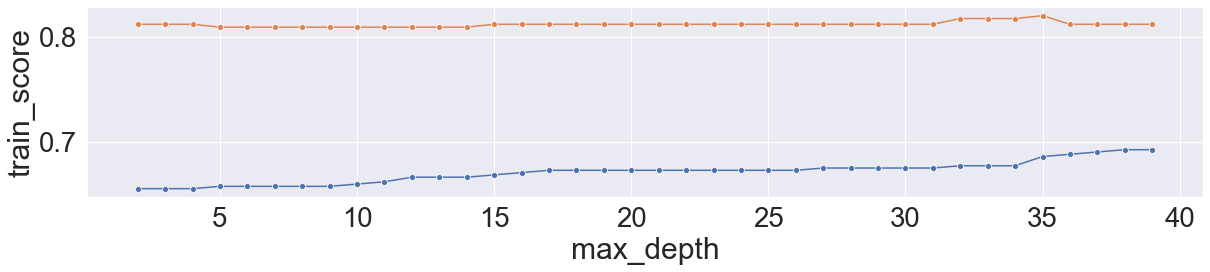

In [111]:
sns.lineplot(data=df, x='max_depth', y='train_score', marker='o')
sns.lineplot(data=df, x='max_depth', y='test_score', marker='o')

## Observation: 
* For the plot above, we could see that training score is way above than testing score, which means that our model has the problem of overfitting. 
* And also, our max_depth does not increase the accuracy of the model too much


### Random Forest

In [112]:
# if you call this with random_state=0 (or any other value), then each and every time, you'll get the same result.
# If int, random_state is the seed used by the random number generator; 
# 

forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, class_weight="balanced", min_samples_leaf=4)


forest.fit(new_array_train1, training_y1)


print("Accuracy on training set: {:.3f}".format(forest.score(new_array_train1, training_y1)))
print("Accuracy on test set: {:.3f}".format(forest.score(new_array_test1, testing_y1)))


estimator = forest.estimators_[3]

Accuracy on training set: 0.911
Accuracy on test set: 0.869


In [113]:
new_array_train1.shape

(459, 4723)

In [114]:
Y_pred_forest = forest.predict(new_array_test1)

#### As you could see, random forest is already doing better than decision tree. And also, we could change some parameters to improve model accuracy

In [115]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [116]:
#### Create the random grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(26,100, num = 10)] # try some sample space and then start from the edge. 
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [4, 8, 12, 16, 20, 24, 28]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#print(n_estimators)

# random_grid_two = {'bootstrap': bootstrap, 'min_samples_leaf': min_samples_leaf, 
#                    'min_samples_split': min_samples_split, 
#                   'max_depth': max_depth}

In [123]:
# search across 100 different combinations, and use all available cores

# Explanation of the parameters based on sklearn documentation: 
# n_iter: Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
# cv: Determines the cross-validation splitting strategy.If we have 10 sets of hyperparameters and are using 5-Fold CV, that represents 50 training loops
# verbose: Controls the verbosity: the higher, the more messages.


rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, n_jobs = -1)


# rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, 
#                                cv = 3, verbose=2, n_jobs= -1) # we could also use GridSearchCV

In [124]:
rf_random.fit(new_array_train1, training_y1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    min_samples_leaf=4,
                                                    n_estimators=50,
                                                    n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [26, 34, 42, 50, 58, 67,
                                                      75, 83, 91, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [4, 8, 12, 16, 20,
                                                              24, 28],
                                        'n_estimators': [40, 57, 75, 93, 111,
                                                         12

In [128]:
min_sample_leaves=[1, 5, 20, 100]
for i in min_sample_leaves:
    forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, class_weight="balanced", min_samples_leaf=i)
    forest.fit(new_array_train1, training_y1)
    print(i)
    print("training score:", forest.score(new_array_train1, training_y1))
    print("testing score:", forest.score(new_array_test1, testing_y1))
    print("    ")

1
training score: 1.0
testing score: 0.8828337874659401
    
5
training score: 0.8605664488017429
testing score: 0.8528610354223434
    
20
training score: 0.7233115468409586
testing score: 0.8119891008174387
    
100
training score: 0.6535947712418301
testing score: 0.8147138964577657
    


In [129]:
rf_random.best_params_

{'n_estimators': 164,
 'min_samples_split': 24,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 67,
 'bootstrap': False}

In [130]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=67,
                       min_samples_split=24, n_estimators=164, n_jobs=-1)

#### use the best params

In [131]:
# random_forest_n2 = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=100,
#                        min_samples_leaf=10, min_samples_split=10, n_estimators=80,
#                        n_jobs=-1)
random_forest_n2 = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=100,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_jobs=-1)


random_forest_n2.fit(new_array_train1, training_y1)
Y_pred_v2 = random_forest_n2.predict(new_array_test1)
Y_pred_forest_prob = random_forest_n2.predict_proba(new_array_test1)[:, 1]

In [132]:
print("training score:", random_forest_n2.score(new_array_train1, training_y1))
print("testing score:", random_forest_n2.score(new_array_test1, testing_y1))

training score: 0.9869281045751634
testing score: 0.896457765667575


In [133]:
Y_pred_forest_prob.shape

(367,)

In [134]:
y_testing_new = pd.Series(testing_y1)

#### We could see here that the testing score got improved from 87 to 89. But our model is still overfitting

### Plotting feature importance

['cornwall', 'enter', 'fool', 'll', 'lord', 'thee', 'thou', 'thy']
[0.02672960617160924, 0.03430342349836968, 0.08086375401351216, 0.022066905667671333, 0.02855790381994564, 0.022645556543009482, 0.038778503315259887, 0.028090850665820302]


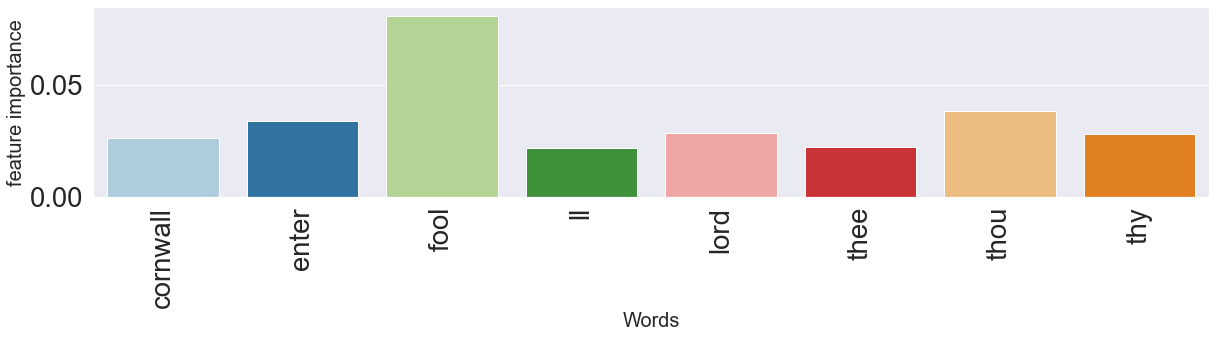

In [135]:
bs_forest = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=100,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_jobs=-1)

bs_forest.fit(new_array_train1, training_y1)


new_lst = [{index: i} for index, i in enumerate(bs_forest.feature_importances_) if i > 0]

def plot_feature_importance(tree):
    feature_importance_lst = [{index: i} for index, i in enumerate(tree.feature_importances_) if i > 0.02]
    keys = []
    vals = []
    words=[]
    for d in feature_importance_lst:
        for k, v in d.items():
            keys.append(k)
            vals.append(v)
    for item in keys:
        words.append(all_words[item])
        
    print(words)
    print(vals)
        
    plt.rcParams["figure.figsize"] = [20, 3.50]
    b = sns.barplot(x=words, y=vals, palette="Paired")
    sns.set(font_scale = 2.5)
    b.set_xlabel('Words', fontsize=20)
    b.set_ylabel('feature importance', fontsize=20)
    plt.xticks(rotation=90)
    
plot_feature_importance(bs_forest)

### Observation: 
* Most of the features are equally important, but "fool" and "thou" are slightly more important than other features. 
* We are separating these two books at the sentence level, and that's why our model has some noise and each word has a relatively low frequency. 

### Model Evaluation:

### confusion matrix

<Figure size 1440x252 with 0 Axes>

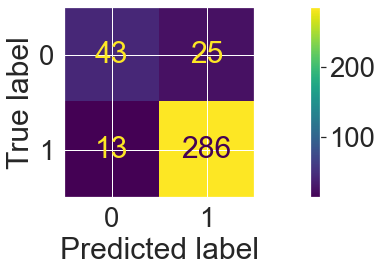

In [136]:
# random forest done by using the "best params"
plt.figure()
plt.figsize=(20,10)
cm = confusion_matrix(testing_y1, Y_pred_v2)
cm_display = ConfusionMatrixDisplay(cm).plot()

<Figure size 1440x252 with 0 Axes>

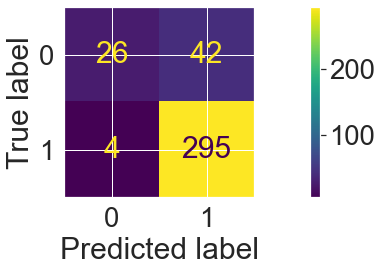

In [137]:
# multi-nomial model
plt.figure()
plt.figsize=(20,10)
cm = confusion_matrix(testing_y1, y_pred_clf)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Observations:
* As we could see here, the first confusion matrix has false positive and far lower false negative.
* Both models have higher false positive than false negative. 

In [138]:
##### Plotting
############## Credit to Karishma Sekhon
def makeSepPlot( varTrue, varPred, title='Classifier Separation', yscale='log', threshold=0.5, pdf=None):

    '''
    Make Classifier seperation plot. Input parameters are: 
      varPred : Required. Variable for model prediction 
      varTrue : Required. Variable for source of truth - actual bundle
      title   : Optional. Title for plot.
    '''
    
    bins =  np.linspace(0, 100, 41)
    plt.hist( varPred[ varTrue == 1 ] *100 , color='red'  , alpha = 0.7, bins = bins, label='Truely Positive'    , lw = 0)
    plt.hist( varPred[ varTrue == 0 ] *100, color='blue' , alpha = 0.5, bins = bins, label='Truely Negative', lw = 0)
    plt.axvline(threshold*100, color='k', linestyle='dashed', linewidth=1)
    plt.yscale(yscale)
    plt.xlabel('Probability of Being Positive')
    plt.ylabel('Counts')
    plt.ylim(bottom=0.9)
    plt.title ( title )
    plt.legend()
    if pdf is not None: 
        pdf.savefig()
    plt.show()


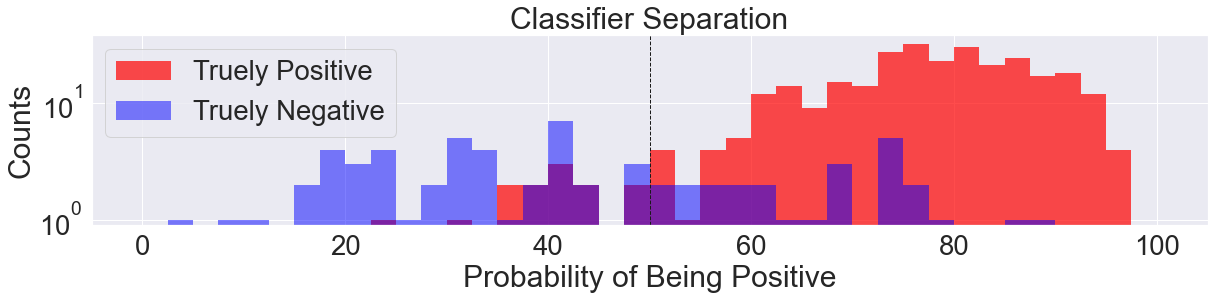

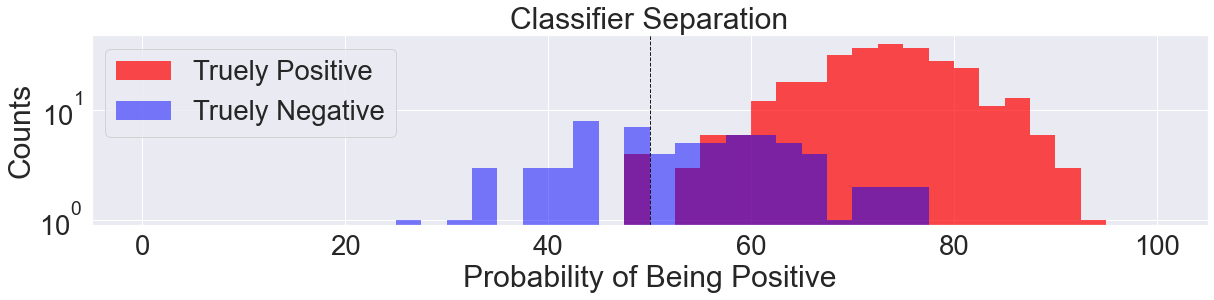

In [139]:
makeSepPlot(y_testing_new, Y_pred_forest_prob, yscale="log") # random forest
makeSepPlot(y_testing_new, Y_pred_multi_prob, yscale="log") # 

### Observations: 
* Here, we compare the Multinomial NB model and random forest model. 
* As we could see here, the random forest model can better classify truly negative (King Lear) than the naive bayes model. (In other words, the naive bayes model has higher false positive)
* In both models, we could see more true positive rate is higher than true negative rate. 

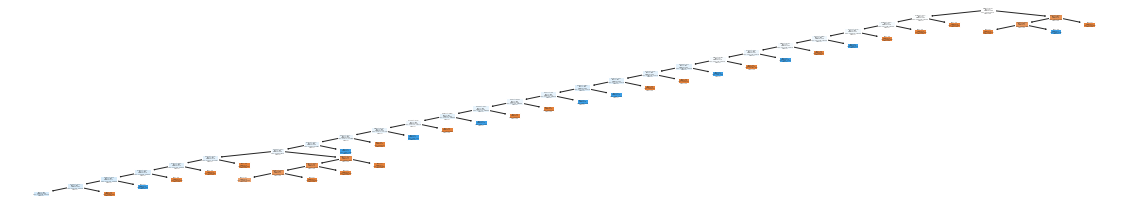

In [74]:
plt.figure()
plt.figsize=(40,10)
tree.plot_tree(bs_forest.estimators_[3], filled=True, class_names=["C.D.", 'S'])
plt.show()